# Telecom Churn Prediction

The goal of this notebook is to provide an overview of how write a notebook and create a submission file that successfully solves the churn prediction problem. Please download the datasets, unzip and place them in the same folder as this notebook.

We are going to follow the process called CRISP-DM.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/639px-CRISP-DM_Process_Diagram.png" style="height: 400px; width:400px;"/>

After Business and Data Understanding via EDA, we want to prepare data for modelling. Then evaluate and submit our predictions.

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1406]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [1407]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [1408]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that you are working with, take notes on which feature you think might impact the churn rate of a user, and what sort of analysis could you do to understand the distribution of the feature better.

In [1409]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


For the purpose of this **starter notebook**, we I will restrict the dataset to only a small set of variables. 

The approach I use here is to understand each Acronym, figure our what variable might be important and filter out variable names based on the combinations of acrynoms using REGEX. So, if I want the total minutes a person has spent on outgoing calls, I need acronyms, TOTAL, OG and MOU. So corresponding regex is ```total.+og.+mou```

In [1410]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [1411]:
# Checking for the columns with a single unique value in the data set
single_value_cols = []
for col in data.columns:
    if data[col].nunique() == 1:
        single_value_cols.append(col)

print(single_value_cols)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']


In [1412]:
for col in single_value_cols:
    print(data[col].value_counts())

circle_id
109    69999
Name: count, dtype: int64
loc_og_t2o_mou
0.0    69297
Name: count, dtype: int64
std_og_t2o_mou
0.0    69297
Name: count, dtype: int64
loc_ic_t2o_mou
0.0    69297
Name: count, dtype: int64
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
last_date_of_month_7
7/31/2014    69600
Name: count, dtype: int64
last_date_of_month_8
8/31/2014    69266
Name: count, dtype: int64
std_og_t2c_mou_6
0.0    67231
Name: count, dtype: int64
std_og_t2c_mou_7
0.0    67312
Name: count, dtype: int64
std_og_t2c_mou_8
0.0    66296
Name: count, dtype: int64
std_ic_t2o_mou_6
0.0    67231
Name: count, dtype: int64
std_ic_t2o_mou_7
0.0    67312
Name: count, dtype: int64
std_ic_t2o_mou_8
0.0    66296
Name: count, dtype: int64


In [1413]:
# Based on the dataset, we remove these columns from the training set
data.drop(single_value_cols, axis=1, inplace=True)

# Based on the dataset, we remove these columns from the test set
unseen.drop(single_value_cols, axis=1, inplace=True)

In [1414]:
# Remove the id column since it is unique for every row from the training set
data.drop('id', axis=1, inplace=True)

In [1415]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 158 entries, arpu_6 to churn_probability
dtypes: float64(126), int64(26), object(6)
memory usage: 84.4+ MB


In [1416]:
# Step 1: Filter numeric columns only
numeric_cols = data.select_dtypes(include=['float', 'int']).columns

# Step 2: Identify columns with only binary values (0, 1) and NaN
categorical_columns = [col for col in numeric_cols if set(data[col].dropna().unique()).issubset({0, 1})]

categorical_columns

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'churn_probability']

In [1417]:
# Generating a list of column names based on their corresponding types

date_columns = data.select_dtypes(include=['object'])

numerical_columns = [col for col in data.columns if col not in date_columns]
numerical_columns = [col for col in numerical_columns if col not in categorical_columns]
numerical_columns

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

In [1418]:
# Dropping date columns as they are not useful for our analysis from the training set
data.drop(columns=date_columns, axis=1, inplace=True)

# Dropping date columns as they are not useful for our analysis from the test set
unseen.drop(columns=date_columns, axis=1, inplace=True)

In [1419]:
# recharge cols fill na with 0
# arpu cols fill na with 0
# cat_cols fill na with -1

#### Recharge Columns

In [1420]:
# Extracting list of columns containing recharge amount
recharge_columns =  data.columns[data.columns.str.contains('rech_amt|rech_data')]
print(recharge_columns,"\n")
print("The are in total",len(recharge_columns),"Columns containing Recharge Amount")

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8'],
      dtype='object') 

The are in total 15 Columns containing Recharge Amount


In [1421]:
# Checking missing values percentages
telecom_df_null_check = 100*data.loc[:,recharge_columns].isnull().sum()/len(data)
telecom_df_null_check = telecom_df_null_check.round(decimals = 2)
telecom_df_null_check

total_rech_amt_6       0.00
total_rech_amt_7       0.00
total_rech_amt_8       0.00
max_rech_amt_6         0.00
max_rech_amt_7         0.00
max_rech_amt_8         0.00
total_rech_data_6     74.90
total_rech_data_7     74.48
total_rech_data_8     73.69
max_rech_data_6       74.90
max_rech_data_7       74.48
max_rech_data_8       73.69
av_rech_amt_data_6    74.90
av_rech_amt_data_7    74.48
av_rech_amt_data_8    73.69
dtype: float64

In [1422]:
# Replacing NaN values in recharge related columns with 0 in the training set
data[recharge_columns] = data[recharge_columns].fillna(0)
print(data[recharge_columns].isnull().sum()*100/data.shape[1])

total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


In [1423]:
# Replacing NaN values in recharge related columns with 0 in the test set
unseen[recharge_columns] = unseen[recharge_columns].fillna(0)
print(unseen[recharge_columns].isnull().sum()*100/unseen.shape[1])

total_rech_amt_6      0.0
total_rech_amt_7      0.0
total_rech_amt_8      0.0
max_rech_amt_6        0.0
max_rech_amt_7        0.0
max_rech_amt_8        0.0
total_rech_data_6     0.0
total_rech_data_7     0.0
total_rech_data_8     0.0
max_rech_data_6       0.0
max_rech_data_7       0.0
max_rech_data_8       0.0
av_rech_amt_data_6    0.0
av_rech_amt_data_7    0.0
av_rech_amt_data_8    0.0
dtype: float64


#### ARPU Columns

In [1424]:
# Columns with 'arpu' information 
arpu_columns = data.columns[data.columns.str.contains('arpu_')]
print(arpu_columns)

Index(['arpu_6', 'arpu_7', 'arpu_8', 'arpu_3g_6', 'arpu_3g_7', 'arpu_3g_8',
       'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8'],
      dtype='object')


In [1425]:
# Checking missing values percentages
telecom_df_null_check = 100*data.loc[:,arpu_columns].isnull().sum()/len(data)
telecom_df_null_check = telecom_df_null_check.round(decimals = 2)
telecom_df_null_check

arpu_6        0.00
arpu_7        0.00
arpu_8        0.00
arpu_3g_6    74.90
arpu_3g_7    74.48
arpu_3g_8    73.69
arpu_2g_6    74.90
arpu_2g_7    74.48
arpu_2g_8    73.69
dtype: float64

In [1426]:
# Replacing NaN values in ARPU related columns with 0 in the training set
data[arpu_columns] = data[arpu_columns].fillna(0)
print(data[arpu_columns].isnull().sum()*100/data.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


In [1427]:
# Replacing NaN values in ARPU related columns with 0 in the test set
unseen[arpu_columns] = unseen[arpu_columns].fillna(0)
print(unseen[arpu_columns].isnull().sum()*100/unseen.shape[1])

arpu_6       0.0
arpu_7       0.0
arpu_8       0.0
arpu_3g_6    0.0
arpu_3g_7    0.0
arpu_3g_8    0.0
arpu_2g_6    0.0
arpu_2g_7    0.0
arpu_2g_8    0.0
dtype: float64


#### Categorical Columns

In [1428]:
# Inspecting categorical columns
data[cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   night_pck_user_6  17568 non-null  float64
 1   night_pck_user_7  17865 non-null  float64
 2   night_pck_user_8  18417 non-null  float64
 3   fb_user_6         17568 non-null  float64
 4   fb_user_7         17865 non-null  float64
 5   fb_user_8         18417 non-null  float64
dtypes: float64(6)
memory usage: 3.2 MB


In [1429]:
# Replacing NaN values in categorical related columns with -1 in the training set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
data[cat_columns] = data[cat_columns].fillna(-1).astype('category')
print(data[cat_columns].isnull().sum()*100/data.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [1430]:
# Verifying the change in dtype on the train set
data[cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  69999 non-null  category
 1   night_pck_user_7  69999 non-null  category
 2   night_pck_user_8  69999 non-null  category
 3   fb_user_6         69999 non-null  category
 4   fb_user_7         69999 non-null  category
 5   fb_user_8         69999 non-null  category
dtypes: category(6)
memory usage: 411.1 KB


In [1431]:
# Replacing NaN values in categorical related columns with -1 in the test set.
# We noticed that the columns listed in `cat_cols` are of the `float64` data type.
# We'll need to convert them to the `category` data type.
unseen[cat_columns] = unseen[cat_columns].fillna(-1).astype('category')
print(unseen[cat_columns].isnull().sum()*100/unseen.shape[1])

night_pck_user_6    0.0
night_pck_user_7    0.0
night_pck_user_8    0.0
fb_user_6           0.0
fb_user_7           0.0
fb_user_8           0.0
dtype: float64


In [1432]:
# Check for columns with more than 70% missing values in the training dataset
mv_train_set = round(100*(data.isna().sum(axis=0)/data.shape[0]), 2)
mv_train_set[mv_train_set > 70].sort_values(ascending=False)

count_rech_2g_6    74.90
count_rech_3g_6    74.90
count_rech_2g_7    74.48
count_rech_3g_7    74.48
count_rech_2g_8    73.69
count_rech_3g_8    73.69
dtype: float64

In [1433]:
# Checking for the columns which have missing values present
mv_train_set[(mv_train_set > 0) & (mv_train_set <= 70)].sort_values(ascending=False)

ic_others_8         5.29
loc_og_t2m_mou_8    5.29
std_og_mou_8        5.29
spl_og_mou_8        5.29
std_og_t2f_mou_8    5.29
                    ... 
std_og_t2f_mou_7    3.84
og_others_7         3.84
std_og_mou_7        3.84
spl_og_mou_7        3.84
isd_og_mou_7        3.84
Length: 81, dtype: float64

In [1434]:
data.shape

(69999, 152)

In [1435]:
# check null values with more than 70 percent of null values in train data.

nullCols = data.columns[data.isnull().mean() * 100 > 0]
null_df_greater_70 = pd.DataFrame(data[nullCols].isnull().mean() * 100 > 70)
null_df_greater_70 = null_df_greater_70.reset_index()
null_df_greater_70.columns = ["col_name", "more_than_70_per_null"]
null_df_greater_70 = null_df_greater_70[null_df_greater_70["more_than_70_per_null"] == True]
null_df_greater_70

,col_name,more_than_70_per_null
81,count_rech_2g_6,True
82,count_rech_2g_7,True
83,count_rech_2g_8,True
84,count_rech_3g_6,True
85,count_rech_3g_7,True
86,count_rech_3g_8,True


In [1436]:
data.shape

(69999, 152)

In [1437]:
#Deleting columns with null values greater than 70 percent.
data = data.drop(columns = null_df_greater_70.col_name, axis=1)
unseen = unseen.drop(columns = null_df_greater_70.col_name, axis=1)

In [1438]:
data.shape

(69999, 146)

In [1439]:
# check null values between 0 to 70 percent of null values in train data.

nullCols = data.columns[data.isnull().mean() * 100 > 0]
null_df_lower_70 = pd.DataFrame(data[nullCols].isnull().mean() * 100 < 70)
null_df_lower_70 = null_df_lower_70.reset_index()
null_df_lower_70.columns = ["col_name", "less_than_70_per_null"]
null_df_lower_70 = null_df_lower_70[null_df_lower_70["less_than_70_per_null"] == True]

In [1440]:
data_to_be_imputed = data[null_df_lower_70["col_name"]]
data_not_to_be_imputed = data.drop(columns=null_df_lower_70["col_name"])

In [1441]:
# Imputing the columns with null values less than 70 percent using KNN Technique
# Initialize KNNImputer with a chosen number of neighbors (e.g., 3)
knn_imputer = KNNImputer(n_neighbors=3)

# Apply KNN imputation
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_to_be_imputed), columns=data_to_be_imputed.columns)

In [1442]:
# Combine the imputed subset with the columns that didn't require imputation
data = pd.concat([data_imputed, data_not_to_be_imputed], axis=1)
data.shape

(69999, 146)

In [1443]:
null_df_lower_70

,col_name,less_than_70_per_null
0,onnet_mou_6,True
1,onnet_mou_7,True
2,onnet_mou_8,True
3,offnet_mou_6,True
4,offnet_mou_7,True
...,...,...
76,isd_ic_mou_7,True
77,isd_ic_mou_8,True
78,ic_others_6,True
79,ic_others_7,True


In [1444]:
unseen_to_be_imputed = unseen[null_df_lower_70["col_name"]]
unseen_not_to_be_imputed = unseen.drop(columns=null_df_lower_70["col_name"])

In [1445]:
# Apply KNN imputation
unseen_imputed = pd.DataFrame(knn_imputer.fit_transform(unseen_to_be_imputed), columns=unseen_to_be_imputed.columns)

In [1446]:
# Combine the imputed subset with the columns that didn't require imputation
unseen = pd.concat([unseen_imputed, unseen_not_to_be_imputed], axis=1)

#### Deriving New Features

Filtering only High Value Customers

In this segment, we'll identify high-value customers aligning with our business objectives, focusing solely on prepaid customers experiencing usage-based churn. We'll evaluate the recharge amounts for June and July, selecting only the top 70% of customers as high-value.

We can create a new feature named Total Data Recharge Amount by multiplying the values of total_rech_data and av_rech_amt_data, which represents the amount recharged by the customer for data usage.

Total Data Recharge Amount = Total Data Recharge * Average Data Recharge Amount
Created another column for total recharge done Total Amount for the months 6 and 7.

Total Amount = Total Data Recharge Amount + Total Recharge Amount
Additionally, we can compute the Total Average Recharge Amount during the 'Good Phase', which includes months 6 and 7.

Total Average Amount = (Total Data Recharge Amount + Total Recharge Amount) / 2

In [1447]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' and 'Action Phase'/'Churn Phase' in the training set
data['total_rech_data_amt_6'] = data['total_rech_data_6'] * data['av_rech_amt_data_6']
data['total_rech_data_amt_7'] = data['total_rech_data_7'] * data['av_rech_amt_data_7']

data['total_amt_6'] = data['total_rech_data_amt_6'] + data['total_rech_amt_6']
data['total_amt_7'] = data['total_rech_data_amt_7'] + data['total_rech_amt_7']

data['total_avg_amt_6_7'] = data[['total_amt_6', 'total_amt_7']].mean(axis=1)

In [1448]:
# Dropping the columns as they are not so useful columns for high value customer or churn

#drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'total_rech_data_6', 'total_rech_data_7']

drop_data_cols = ['total_rech_data_amt_6', 'total_rech_data_amt_7', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
                  'total_rech_data_6', 'total_rech_data_7', 'av_rech_amt_data_8', 'total_rech_data_8']

data.drop(drop_data_cols, axis=1, inplace=True)

In [1449]:
#data['total_rech_data_amt_8'] = data['total_rech_data_8'] * data['av_rech_amt_data_8']
#data['total_avg_amt_8'] = data['total_rech_data_amt_8'] + data['total_rech_amt_8']

In [1450]:
# Checking for any null value in the derived column in the training set
data['total_avg_amt_6_7'].isnull().sum()

0

In [1451]:
#data[['total_avg_amt_6_7', 'total_amt_6', 'total_amt_7', 'total_avg_amt_8', 'churn_probability']]

In [1452]:
# Deriving new columns for Total Data Recharge Amount for the 'Good Phase' in the test set
unseen['total_rech_data_amt_6'] = unseen['total_rech_data_6'] * unseen['av_rech_amt_data_6']
unseen['total_rech_data_amt_7'] = unseen['total_rech_data_7'] * unseen['av_rech_amt_data_7']

unseen['total_amt_6'] = unseen['total_rech_data_amt_6'] + unseen['total_rech_amt_6']
unseen['total_amt_7'] = unseen['total_rech_data_amt_7'] + unseen['total_rech_amt_7']

unseen['total_avg_amt_6_7'] = unseen[['total_amt_6', 'total_amt_7']].mean(axis=1)

# Dropping the drop_data_cols from the test set
unseen.drop(drop_data_cols, axis=1, inplace=True)

In [1453]:
#unseen['total_rech_data_amt_8'] = unseen['total_rech_data_8'] * unseen['av_rech_amt_data_8']
#unseen['total_avg_amt_8'] = unseen['total_rech_data_amt_8'] + unseen['total_rech_amt_8']

In [1454]:
#unseen[['total_avg_amt_6_7', 'total_amt_6', 'total_amt_7', 'total_avg_amt_8']]

In [1455]:
data.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_amt_6,total_amt_7,total_avg_amt_6_7
0,48.58,124.38,1.29,32.24,96.68,2.33,0.00,0.0,0.0,0.00,...,-1.0,-1.0,1958,0.0,0.0,0.0,0,77.0,65.0,71.0
1,0.00,0.00,0.00,0.00,25.99,30.89,0.00,0.0,0.0,0.00,...,1.0,-1.0,710,0.0,0.0,0.0,0,0.0,290.0,145.0
2,0.53,15.93,0.00,53.99,82.05,0.00,0.00,0.0,0.0,0.00,...,-1.0,-1.0,882,0.0,0.0,0.0,0,70.0,120.0,95.0
3,7.26,16.01,0.00,68.76,78.48,50.23,0.00,0.0,0.0,0.00,...,-1.0,-1.0,982,0.0,0.0,0.0,0,160.0,240.0,200.0
4,21.28,4.83,6.13,56.99,38.11,9.63,53.64,0.0,0.0,15.73,...,1.0,1.0,647,0.0,0.0,0.0,0,1515.0,1473.0,1494.0


In [1456]:
data['total_avg_amt_6_7'].describe()

count    69999.000000
mean       485.760093
std        861.075228
min          0.000000
25%        128.000000
50%        275.500000
75%        553.000000
max      37762.500000
Name: total_avg_amt_6_7, dtype: float64

In [1457]:
# Finding cutoff value for only the top 75% of high-value customers from the 'Good Phase'
# Considering 75% percentile as this column's max of the interquartile range.
cutoff = np.percentile(data['total_avg_amt_6_7'], 75)
cutoff

553.0

In [1458]:
# Filter high value customers in the new dataframe (high_val_train) where total recharge is more than 553
high_val_train = data[(data['total_avg_amt_6_7'] > cutoff)].copy()

print(high_val_train.shape)

(17495, 143)


Analysing our target variable churn_probability and Class Imbalance

In [1459]:
high_val_train['churn_probability'].dtype
high_val_train['churn_probability'] = high_val_train['churn_probability'].astype('category')
high_val_train['churn_probability'].dtype

CategoricalDtype(categories=[0, 1], ordered=False, categories_dtype=int64)

In [1460]:
# Check the value counts of churn and not-churn
print(high_val_train['churn_probability'].value_counts())

print('-------------------------------------------------')

# Calculate churn ratio
print('Churn ratio:')
print(high_val_train['churn_probability'].value_counts()*100/high_val_train.shape[0])

churn_probability
0    16071
1     1424
Name: count, dtype: int64
-------------------------------------------------
Churn ratio:
churn_probability
0    91.860532
1     8.139468
Name: count, dtype: float64


In [1461]:
final_df = high_val_train

In [1462]:
final_unseen_df = unseen

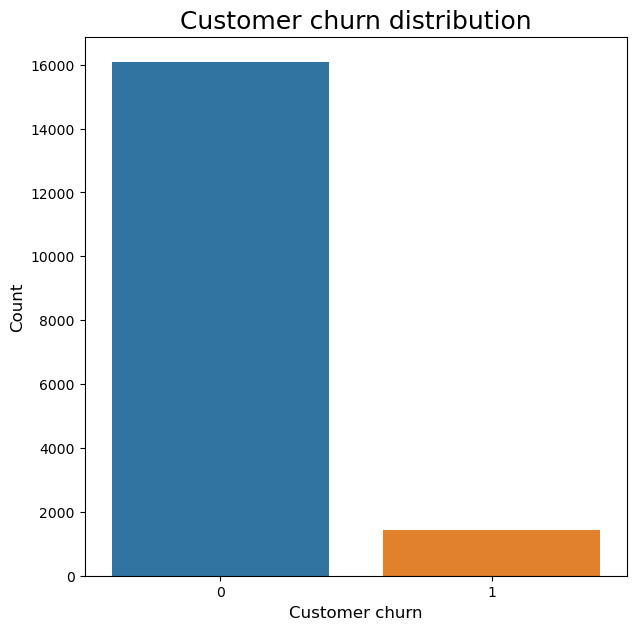

In [1463]:
# Visualize churn distribution
plt.figure(figsize=(7, 7))
sns.countplot(x = final_df['churn_probability'])
plt.xlabel('Customer churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Customer churn distribution', fontsize=18)
plt.show()

#### Exploratory Data Analysis (EDA)

In [1464]:
def plot_bar_graph(title, month, y_list, data):
    plt.figure(figsize=(15, 10))
    
    for i, m in enumerate(month):
        plt.subplot(2, 3, i+1)
        plt.title(f'{title} for {m}')
        sns.barplot(x='churn_probability', y=y_list[i], data=data)
    
    plt.tight_layout()
    plt.show()

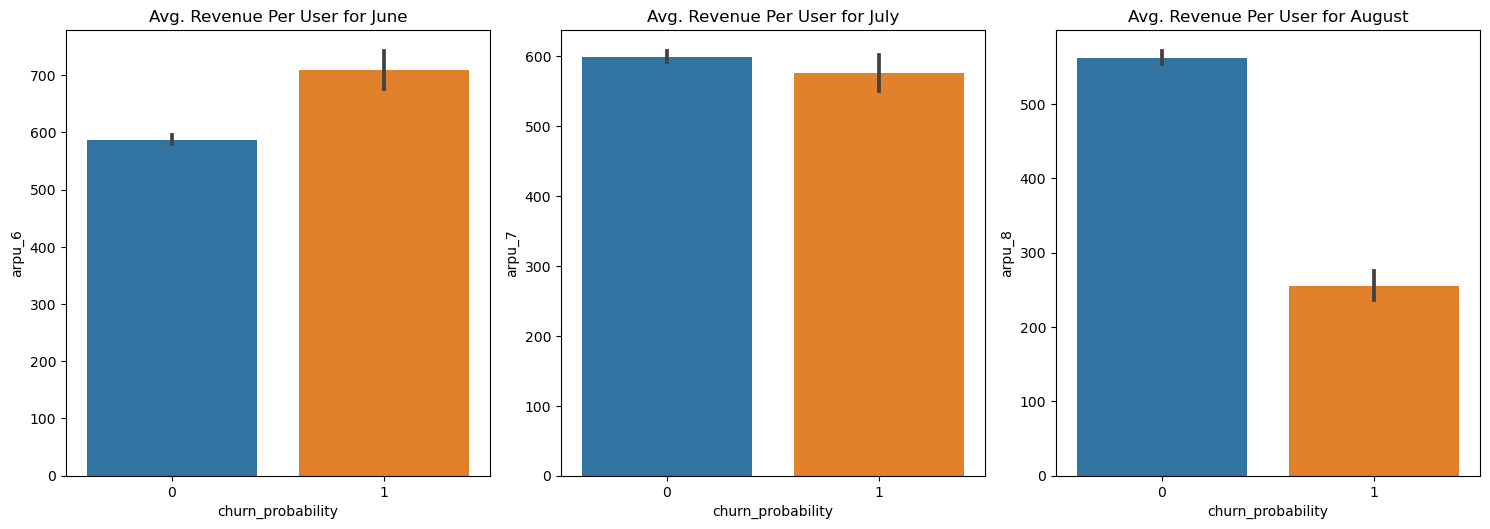

In [1465]:
# Visualising Average Revenue per user
arpu_cols = ['arpu_6', 'arpu_7', 'arpu_8']
plot_bar_graph('Avg. Revenue Per User', ['June', 'July', 'August'], arpu_cols, final_df)

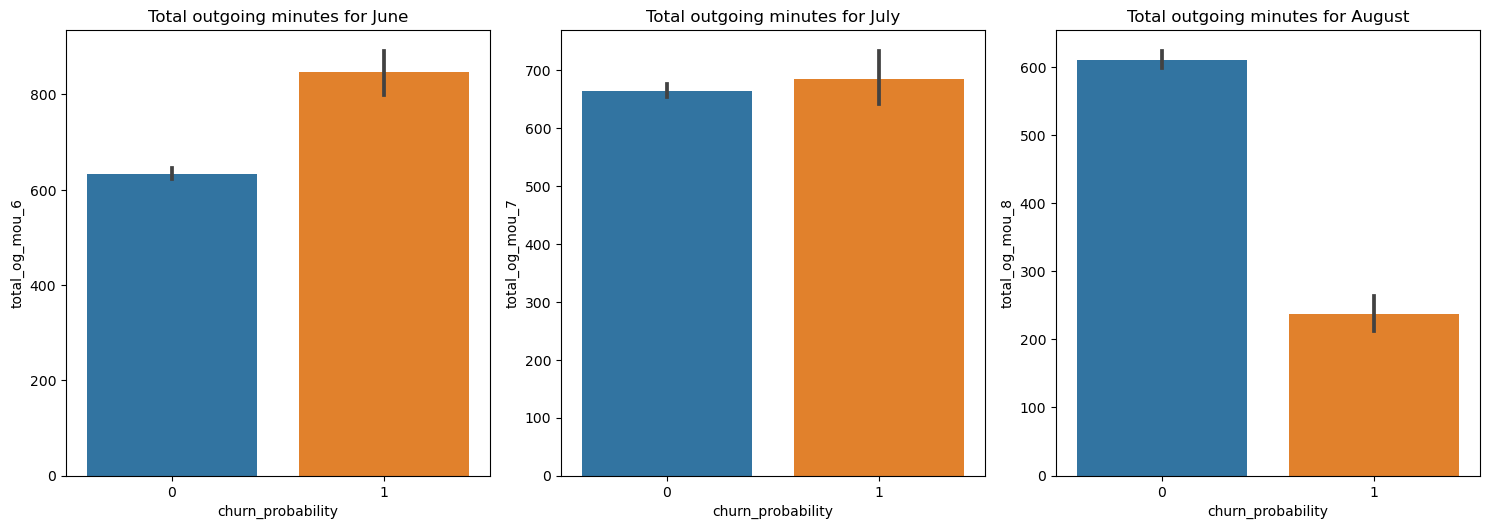

In [1466]:
# Visualising Outgoing minutes of usage
total_og_mou_cols = ['total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8']
plot_bar_graph('Total outgoing minutes', ['June', 'July', 'August'], total_og_mou_cols, final_df)

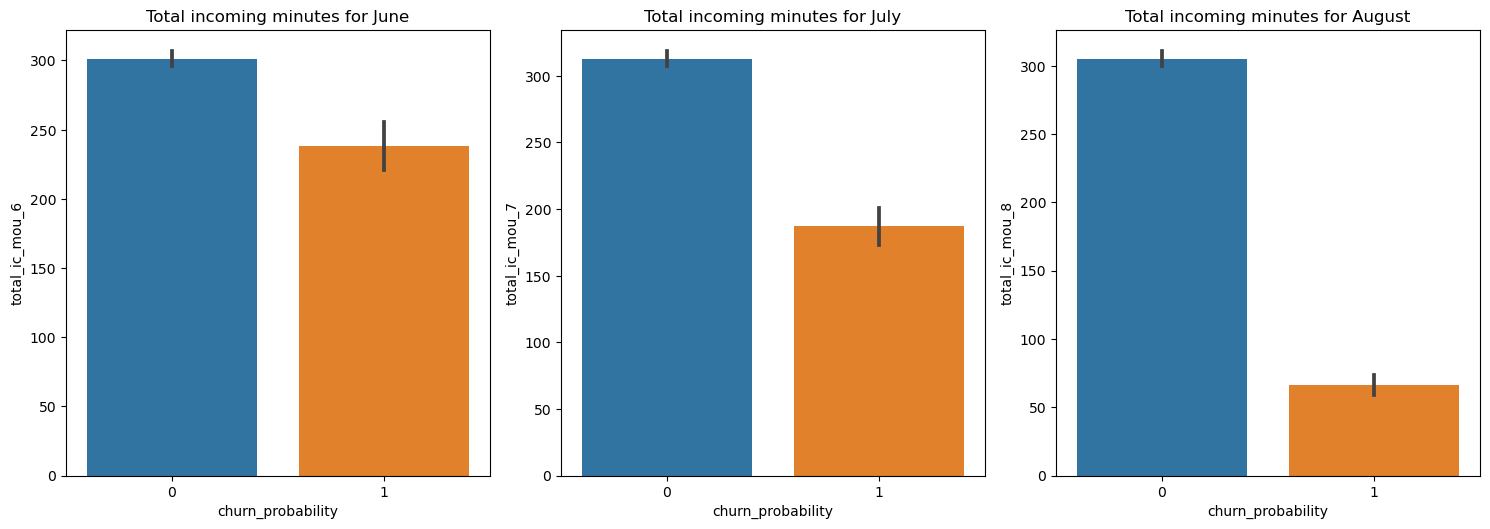

In [1467]:
# Visualising incoming minutes of usage
total_ic_mou_cols = ['total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8']
plot_bar_graph('Total incoming minutes', ['June', 'July', 'August'], total_ic_mou_cols, final_df)

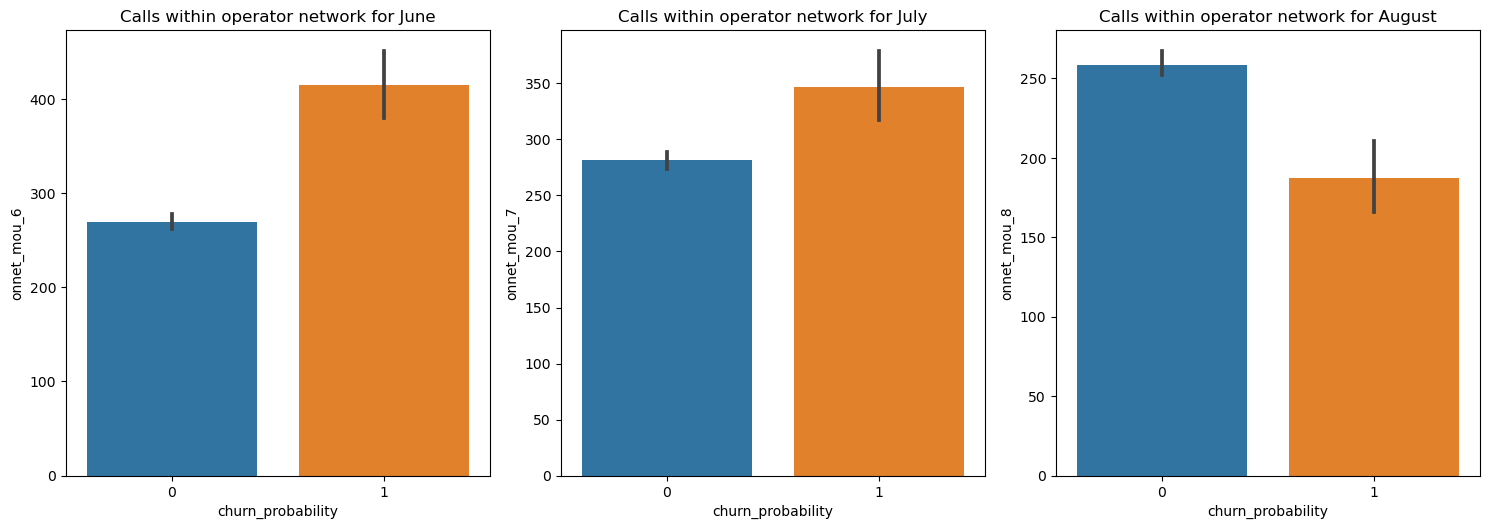

In [1468]:
# Visualizing all types of calls within the operator's network.
onnet_mou_cols = ['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8']
plot_bar_graph('Calls within operator network', ['June', 'July', 'August'], onnet_mou_cols, final_df)

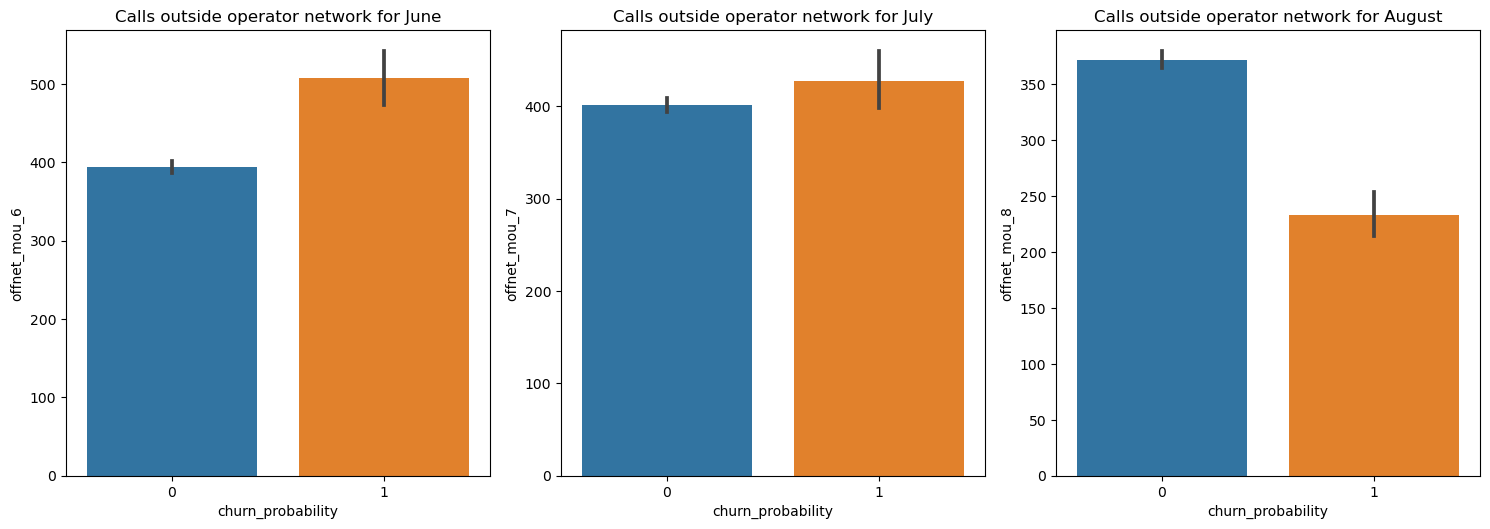

In [1469]:
# Visualizing all types of calls made outside the operator network.
offnet_mou_cols = ['offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8']
plot_bar_graph('Calls outside operator network', ['June', 'July', 'August'], offnet_mou_cols, final_df)

In [1470]:
# Analysing different metrics by extracting them into columns of similar type
amount_data = final_df.loc[:, final_df.columns.str.contains('amt')]
rech_data = final_df.loc[:, final_df.columns.str.contains('rech')]
total_data = final_df.loc[:, final_df.columns.str.contains('tot')]
net_mou_data = final_df.loc[:, final_df.columns.str.contains('net_mou')]

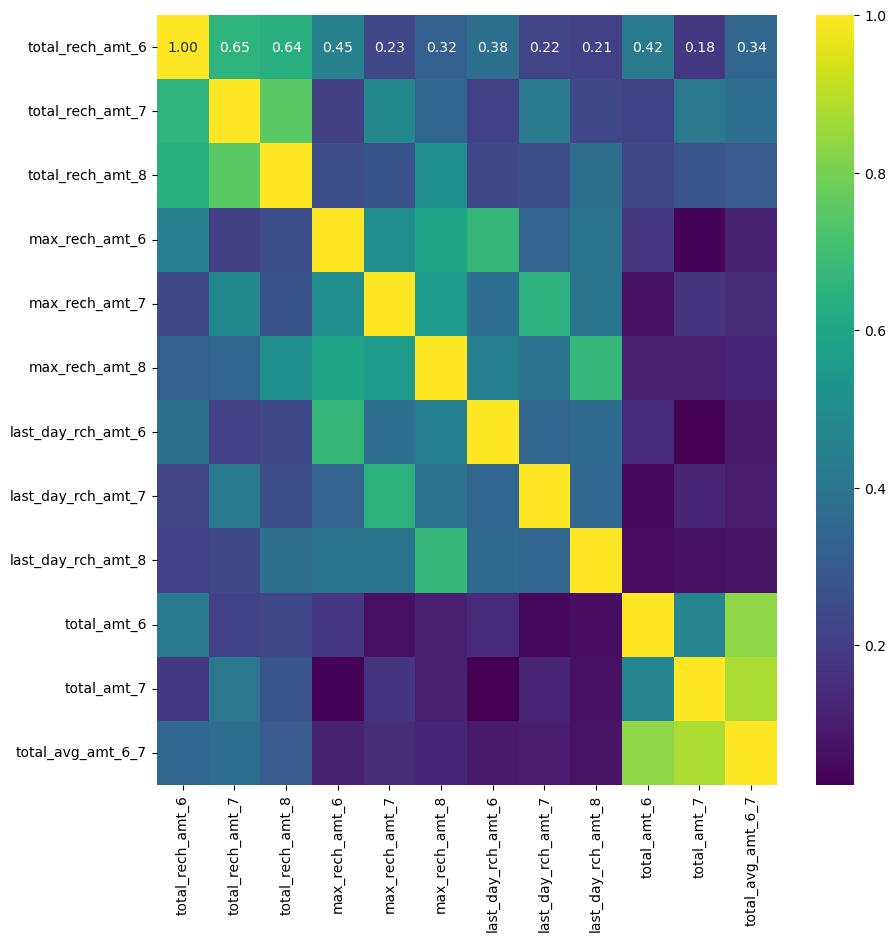

In [1471]:
# Amount data
plt.figure(figsize=(10,10))
sns.heatmap(amount_data.corr(), annot=True, cmap='viridis', fmt=".2f")
plt.show()

Observations:

A substantial correlation of 74% exists between the total recharge amount in month 7 and month 8.
Similarly, a notable correlation of 68% is observed between the maximum recharge amount in month 8 and the last day's recharge amount in the same month.
This suggests that customers who are unlikely to churn tend to recharge higher amounts in month 8.

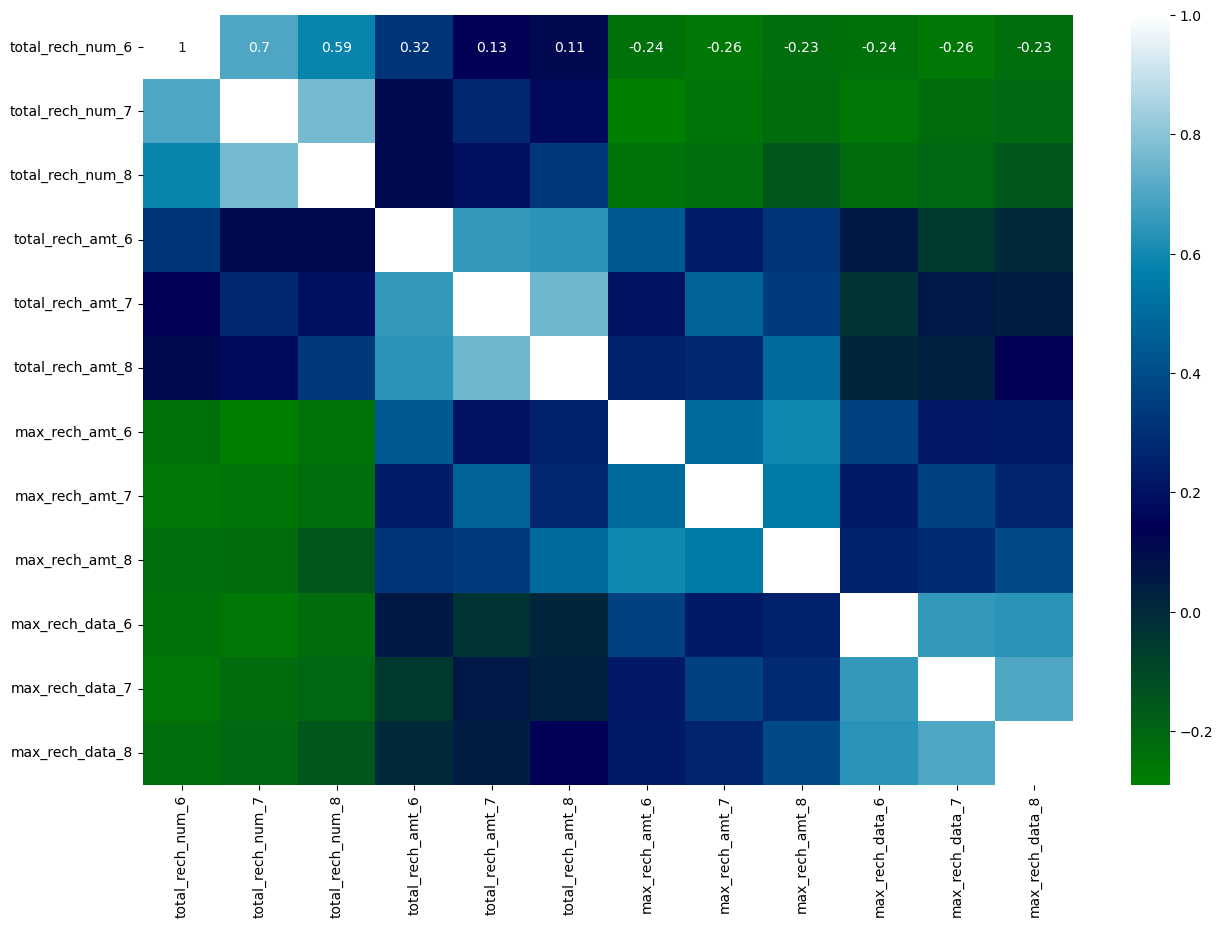

In [1472]:
#rech_data
plt.figure(figsize=(15,10))
sns.heatmap(rech_data.corr(), annot=True, cmap='ocean')
plt.show()

Observations:

A significant correlation of 76% exists between the total recharge for month 7 and the recharge for month 8.

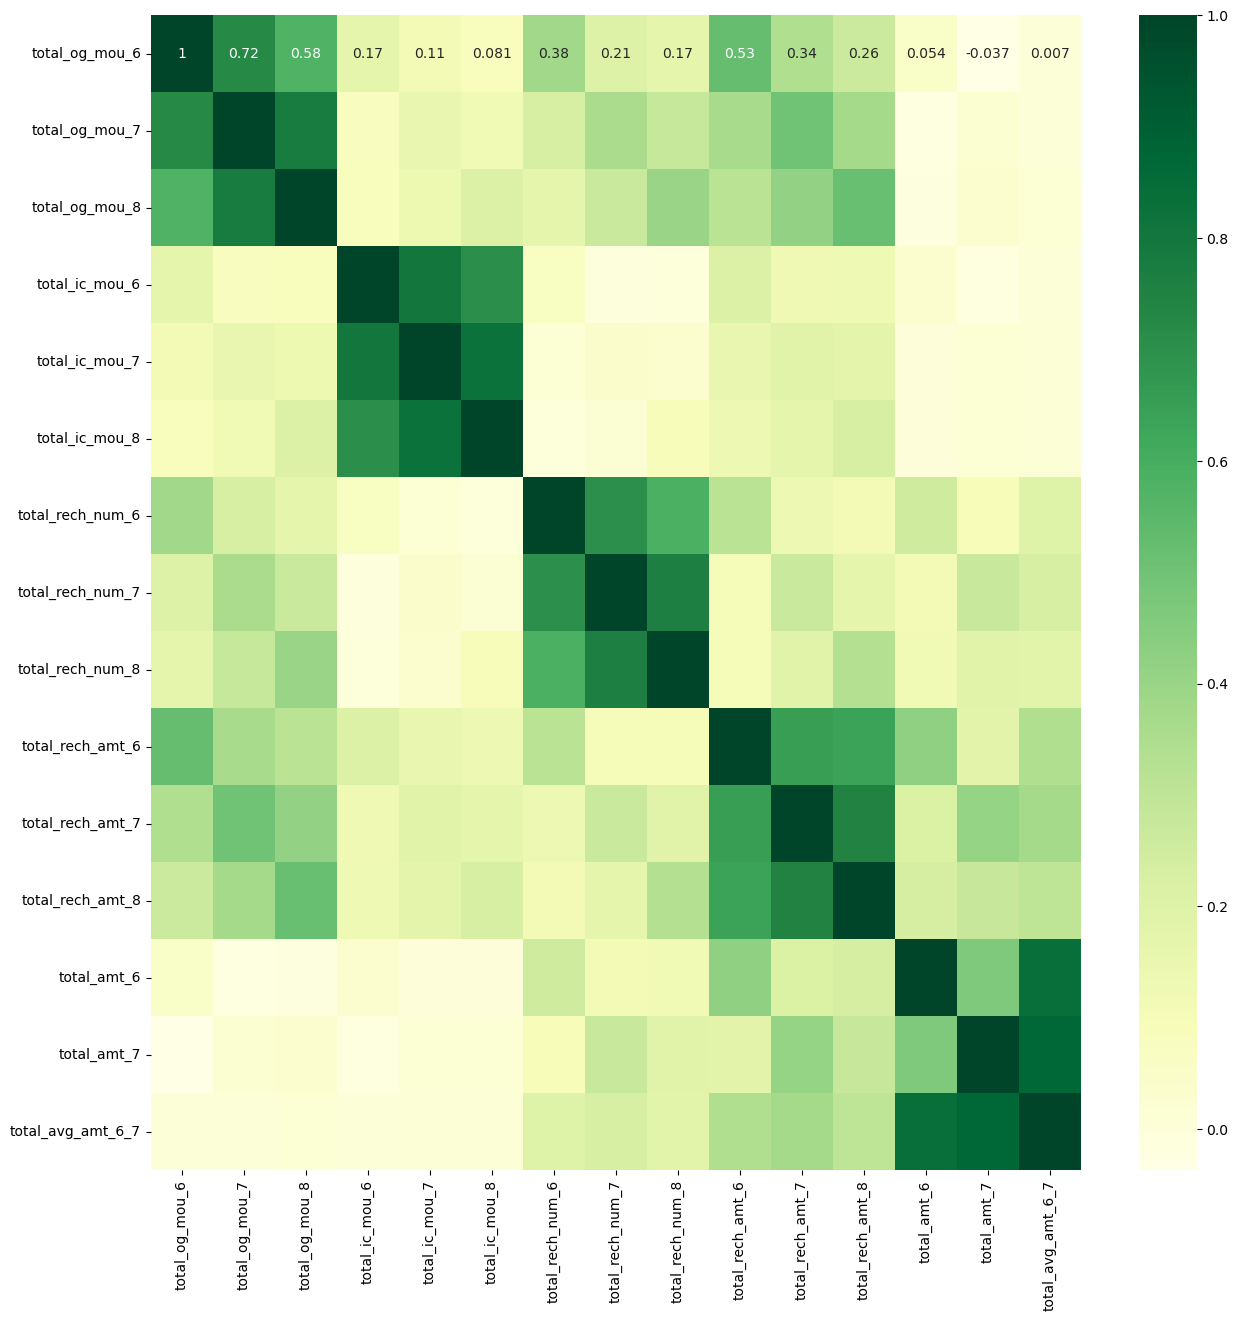

In [1473]:
#total_data
plt.figure(figsize=(15,15))
sns.heatmap(total_data.corr(), annot=True, cmap='YlGn')
plt.show()

Observations:

There exists a remarkably high correlation between the incoming (82%) and outgoing minutes (77%) of usage in months 7 and 8.
Heavy usage suggests that customers are less likely to churn.

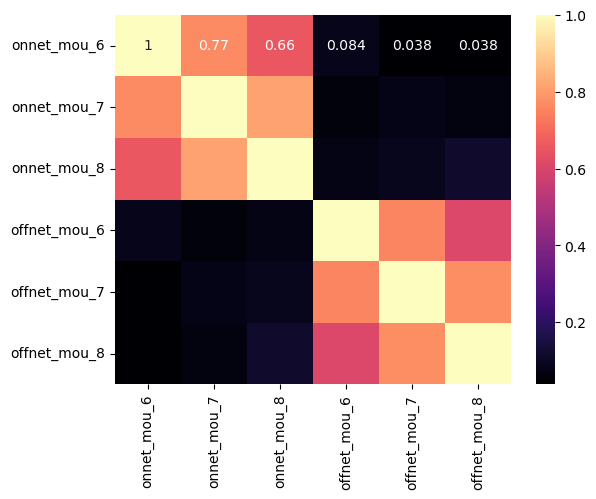

In [1474]:
#net_mou_data
sns.heatmap(net_mou_data.corr(), annot=True, cmap='magma')
plt.show()

Observations:
A significant correlation is observed between the on-net and off-net usage minutes in both months 7 and 8.

 #### Dummy Variable Creation (One Hot Encoding)

In [1475]:
# Creating dummies for categorical columns
dummy_df = pd.get_dummies(final_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')

In [1476]:
final_df = pd.concat([final_df, dummy_df], axis=1)
# drop the category cols
final_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17495 entries, 4 to 69994
Columns: 149 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: category(1), float64(111), int32(12), int64(25)
memory usage: 19.1 MB


In [1477]:
final_df.shape

(17495, 149)

In [1478]:
# Test Data
# Creating dummies for categorical columns
dummy_unseen_df = pd.get_dummies(final_unseen_df[['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6']], drop_first=True, dtype='int')
final_unseen_df = pd.concat([final_unseen_df, dummy_unseen_df], axis=1)
# drop the category cols
final_unseen_df.drop(['night_pck_user_8', 'fb_user_8', 'fb_user_7', 'fb_user_6', 'night_pck_user_7', 'night_pck_user_6'], axis=1, inplace=True)
final_unseen_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 149 entries, onnet_mou_6 to night_pck_user_6_1.0
dtypes: float64(111), int32(12), int64(26)
memory usage: 32.7 MB


In [1479]:
final_unseen_df.shape

(30000, 149)

#### Outlier Treatment

In [1480]:
# Checking outliers at 25%, 50%, 75%, 90%, 95% and 99%
final_df.describe(percentiles=[0.05, .25, .50, .75, .90, .95, .99])

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
count,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,...,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000,17495.000000
mean,281.590942,286.785051,252.740980,402.637652,403.548499,360.613100,17.197617,13.792808,13.399343,29.939716,...,0.055502,0.510489,0.044527,0.561475,0.041726,0.555530,0.591883,0.014118,0.582624,0.014633
std,493.535049,516.583176,491.431322,510.437834,521.111514,499.110183,80.602888,81.047464,77.864852,128.507447,...,0.228963,0.499904,0.206269,0.496221,0.199969,0.496921,0.491499,0.117982,0.493140,0.120081
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,3.160000,2.624000,0.730000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.580000,18.040000,14.325000,80.830000,76.660000,59.860000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,92.790000,90.580000,75.380000,235.680000,230.530000,199.860000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
75%,307.885000,304.860000,258.515000,524.400000,530.335000,467.910000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
90%,818.570000,847.552000,706.518000,975.580000,982.020000,886.246000,31.170000,16.157333,17.322000,57.482000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
95%,1240.412000,1280.345000,1146.657000,1361.095000,1355.205000,1237.188000,93.317000,62.860000,60.854000,166.620000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000


In [1481]:
def cap_outliers(array, k=5):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [1482]:
# Handle outliers of numerical columns in the train set
numerical_cols = [col for col in data.columns if col not in date_columns]
numerical_cols = [col for col in numerical_cols if col not in categorical_columns]
final_df[numerical_cols] = final_df[numerical_cols].apply(cap_outliers, axis=0)

In [1483]:
final_df.shape

(17495, 149)

In [1484]:
# Handle outliers of numerical columns in the unseen set
final_unseen_df[numerical_cols] = final_unseen_df[numerical_cols].apply(cap_outliers, axis=0)

In [1485]:
final_unseen_df.shape

(30000, 149)

#### Model Building and Evaluation

In [1486]:
# Partitioning the dataset into the feature variable 'X' and the response variable 'y'.
X = final_df.drop(['churn_probability'], axis=1)
y = final_df['churn_probability']

In [1487]:
# Train test split - 80% training data, 20% validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=100)

In [1488]:
# Checking the shape after split
print('X_train Shape:', X_train.shape)
print('y_train Shape:', y_train.shape)
print('X_val Shape:', X_val.shape)
print('y_val Shape:', y_val.shape)

X_train Shape: (13996, 148)
y_train Shape: (13996,)
X_val Shape: (3499, 148)
y_val Shape: (3499,)


In [1489]:
y_train.value_counts()

churn_probability
0    12846
1     1150
Name: count, dtype: int64

#### Handling Data Imbalance using Synthetic Minority Over-sampling Technique (SMOTE)

In [1490]:
smt = SMOTE(random_state=2)
X_train_smote, y_train_smote = smt.fit_resample(X_train, y_train)

In [1491]:
X_train_smote.shape

(25692, 148)

In [1492]:
y_train_smote.shape

(25692,)

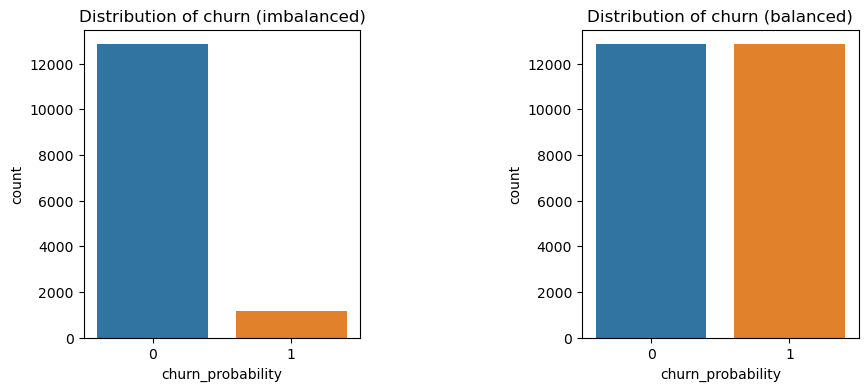

In [1493]:
# Checking the distribution on our target variable 'y_train' before and after SMOTE
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.title("Distribution of churn (imbalanced)")
sns.countplot(x=y_train)

plt.subplot(1,2,2)
plt.title("Distribution of churn (balanced)")
sns.countplot(x=y_train_smote)

plt.subplots_adjust(wspace=0.8)
plt.show()

#### Feature Scaling using SandardScaler - Training Data

In [1494]:
# Use SandardScaler to scale values
scaler = StandardScaler()

# Fit and transform training set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_smote), columns = X_train_smote.columns, index = X_train_smote.index)

# Only Transform validation set
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns, index = X_val.index)

#### Feature Scaling using SandardScaler - Unseen Test Data

In [1495]:
unseen_id_df = final_unseen_df.pop("id")

In [1496]:
# Only Transform validation set
final_unseen_df_scaled = pd.DataFrame(scaler.transform(final_unseen_df), columns = final_unseen_df.columns, index = final_unseen_df.index)

In [1497]:
unseen_id_df = pd.DataFrame(unseen_id_df)

In [1498]:
unseen_id_df.head()

,id
0,69999
1,70000
2,70001
3,70002
4,70003


In [1499]:
final_unseen_df_scaled.head()

,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,...,fb_user_8_0.0,fb_user_8_1.0,fb_user_7_0.0,fb_user_7_1.0,fb_user_6_0.0,fb_user_6_1.0,night_pck_user_7_0.0,night_pck_user_7_1.0,night_pck_user_6_0.0,night_pck_user_6_1.0
0,-0.577890,-0.563591,-0.471257,-0.703135,-0.720312,-0.635208,-0.309756,-0.294413,-0.317375,-0.324282,...,-0.186881,-0.669517,-0.166126,-0.856711,-0.161998,-0.910996,-0.893605,-0.088798,-0.930627,-0.092294
1,-0.492748,-0.521507,-0.479504,0.064085,0.422741,0.251084,-0.309756,-0.294413,-0.317375,-0.324282,...,-0.186881,-0.669517,-0.166126,-0.856711,-0.161998,-0.910996,-0.893605,-0.088798,-0.930627,-0.092294
2,-0.625086,-0.588403,-0.508356,-0.783121,-0.693853,-0.610079,0.094473,1.559022,0.195722,-0.086784,...,-0.186881,-0.669517,-0.166126,-0.856711,-0.161998,-0.910996,-0.893605,-0.088798,-0.930627,-0.092294
3,-0.629427,-0.599837,-0.529541,-0.740405,-0.385255,-0.661838,-0.309756,-0.294413,-0.317375,-0.324282,...,-0.186881,-0.669517,-0.166126,-0.856711,-0.161998,-0.910996,-0.893605,-0.088798,-0.930627,-0.092294
4,0.238198,0.617473,1.237599,-0.701690,-0.736440,-0.538410,-0.309756,-0.294413,-0.317375,-0.324282,...,-0.186881,-0.669517,-0.166126,-0.856711,-0.161998,-0.910996,-0.893605,-0.088798,-0.930627,-0.092294


In [1500]:
def calculate_classification_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix')
    print()
    print(cm)
    
    # True Positives, False Positives, True Negatives, False Negatives
    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    # Accuracy Score
    accuracy = round((TP + TN) / (TP + FP + TN + FN), 4)

    # Sensitivity (Recall or True Positive Rate)
    sensitivity = round(TP / (TP + FN), 4)

    # Specificity
    specificity = round(TN / (TN + FP), 4)

    # Precision
    precision = round(TP / (TP + FP), 4)

    # False Positive Rate
    false_positive_rate = round(FP / (FP + TN), 4)

    # True Positive Rate
    true_positive_rate = sensitivity

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'False Positive Rate', 'True Positive Rate'],
        'Value': [accuracy, sensitivity, specificity, precision, false_positive_rate, true_positive_rate]
    })

    return metrics_df

In [1501]:
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs,drop_intermediate = False)
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

#### Model 1 : Logistic Regression with Recursive Feature Elimination (RFE)

In [1502]:
# Select top 20 features using RFE
logreg = LogisticRegression(max_iter=1000, tol=0.001, solver='sag')
rfe = RFE(logreg, n_features_to_select=20)
rfe = rfe.fit(X_train_scaled, y_train_smote)

In [1503]:
list(zip(X_train_scaled.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_6', False, 94),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', False, 35),
 ('offnet_mou_6', False, 28),
 ('offnet_mou_7', False, 3),
 ('offnet_mou_8', False, 41),
 ('roam_ic_mou_6', False, 123),
 ('roam_ic_mou_7', False, 57),
 ('roam_ic_mou_8', False, 77),
 ('roam_og_mou_6', False, 95),
 ('roam_og_mou_7', False, 124),
 ('roam_og_mou_8', False, 40),
 ('loc_og_t2t_mou_6', False, 60),
 ('loc_og_t2t_mou_7', False, 105),
 ('loc_og_t2t_mou_8', False, 39),
 ('loc_og_t2m_mou_6', False, 23),
 ('loc_og_t2m_mou_7', False, 119),
 ('loc_og_t2m_mou_8', False, 42),
 ('loc_og_t2f_mou_6', False, 86),
 ('loc_og_t2f_mou_7', False, 100),
 ('loc_og_t2f_mou_8', False, 101),
 ('loc_og_t2c_mou_6', False, 68),
 ('loc_og_t2c_mou_7', False, 82),
 ('loc_og_t2c_mou_8', False, 50),
 ('loc_og_mou_6', False, 59),
 ('loc_og_mou_7', False, 80),
 ('loc_og_mou_8', False, 103),
 ('std_og_t2t_mou_6', False, 26),
 ('std_og_t2t_mou_7', False, 2),
 ('std_og_t2t_mou_8', True, 1),
 ('std_og_t2m_mou_6', False, 114),
 

In [1504]:
# Selected features using RFE
selected_features = X_train_scaled.columns[rfe.support_]
selected_features

Index(['onnet_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_8', 'total_og_mou_8', 'total_ic_mou_7', 'total_ic_mou_8',
       'max_rech_data_7', 'sachet_2g_7', 'fb_user_8_1.0',
       'night_pck_user_7_0.0'],
      dtype='object')

In [1505]:
X_train_scaled_final = X_train_scaled[selected_features]
logreg.fit(X_train_scaled_final, y_train_smote)

LogisticRegression(max_iter=1000, solver='sag', tol=0.001)

In [1506]:
y_train_smote_pred = logreg.predict(X_train_scaled_final)

In [1507]:
# Calculate metrics on the training set
calculate_classification_metrics(y_train_smote, y_train_smote_pred)

Confusion Matrix

[[10617  2229]
 [ 1518 11328]]


,Metric,Value
0,Accuracy,0.8542
1,Sensitivity,0.8818
2,Specificity,0.8265
3,Precision,0.8356
4,False Positive Rate,0.1735
5,True Positive Rate,0.8818


In [1508]:
# Retain only the selected feature from the final model
X_val_scaled_final = X_val_scaled[selected_features]
X_val_scaled_final.head()

,onnet_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,total_og_mou_8,total_ic_mou_7,total_ic_mou_8,max_rech_data_7,sachet_2g_7,fb_user_8_1.0,night_pck_user_7_0.0
51639,-0.563771,-0.406649,-0.444445,-0.546536,-0.043847,-0.489571,-0.681159,-0.703153,-0.313045,-0.395973,-0.429037,-0.289209,-0.250378,-0.664607,-0.797114,-0.651056,-0.650515,-0.469038,-0.669517,-0.893605
58127,-0.604170,-0.406649,-0.444445,-0.546536,-0.043847,-0.346753,-0.648850,-0.626132,-0.298602,-0.395973,-0.423094,2.488131,-0.250378,-0.664607,-0.654231,-0.584365,-0.216219,1.469538,1.493615,1.119063
5267,0.504863,0.087103,-0.409621,-0.204962,-0.043847,-0.122021,0.064137,-0.017263,-0.119511,-0.337249,-0.310310,-0.289209,-0.250378,0.315518,-0.111616,-0.046165,-0.650515,-0.469038,-0.669517,-0.893605
21137,-0.332252,-0.368422,-0.208990,-0.261230,-0.043847,-0.007071,1.496535,1.065667,0.013685,0.682482,0.636602,-0.289209,-0.250378,0.609236,1.222474,1.117139,-0.650515,-0.469038,-0.669517,-0.893605
44191,-0.592415,-0.406649,-0.444445,-0.546536,-0.043847,-0.245849,-0.370399,-0.355997,-0.313045,-0.395973,-0.419792,-0.289209,-0.250378,-0.591514,-0.529294,-0.358862,0.803433,-0.469038,1.493615,1.119063


In [1509]:
# Get the predicted values from the linear model
y_val_pred = logreg.predict(X_val_scaled_final)

In [1510]:
confusion = confusion_matrix(y_true=y_val, y_pred=y_val_pred)
print(confusion)

[[2676  549]
 [  58  216]]


In [1511]:
# Calculate metrics
metrics_df = calculate_classification_metrics(y_true=y_val, y_pred=y_val_pred)
metrics_df

Confusion Matrix

[[2676  549]
 [  58  216]]


,Metric,Value
0,Accuracy,0.8265
1,Sensitivity,0.7883
2,Specificity,0.8298
3,Precision,0.2824
4,False Positive Rate,0.1702
5,True Positive Rate,0.7883


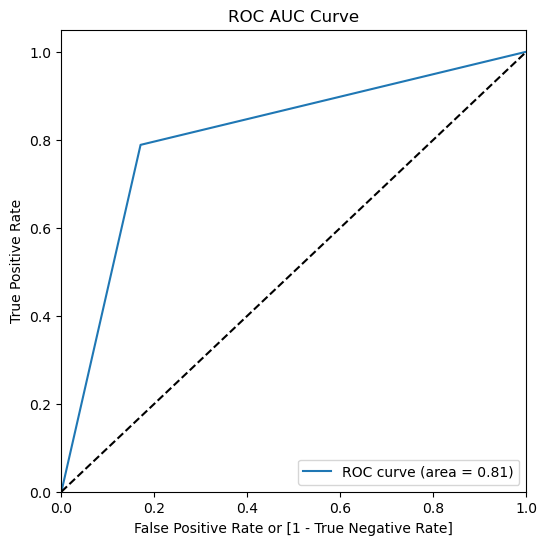

In [1512]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [1513]:
# ROC AUC Score
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.81'

#### Model 2 : Logistic Regression with PCA

In [1514]:
lr = LogisticRegression(random_state=42)
pca_components = PCA(n_components=20)

In [1515]:
X_train_scaled_pca = pca_components.fit_transform(X_train_scaled)

In [1516]:
X_val_scaled_pca = pca_components.transform(X_val_scaled)

In [1517]:
logreg_pca = lr.fit(X_train_scaled_pca, y_train_smote)

In [1518]:
y_val_pred_pca = logreg_pca.predict(X_val_scaled_pca)

In [1519]:
confusion_pca = confusion_matrix(y_true=y_val, y_pred=y_val_pred_pca)
print(confusion_pca)

[[2596  629]
 [  65  209]]


In [1520]:
metrics_pca_df = calculate_classification_metrics(y_true=y_val, y_pred=y_val_pred_pca)
metrics_pca_df

Confusion Matrix

[[2596  629]
 [  65  209]]


,Metric,Value
0,Accuracy,0.8017
1,Sensitivity,0.7628
2,Specificity,0.8050
3,Precision,0.2494
4,False Positive Rate,0.1950
5,True Positive Rate,0.7628


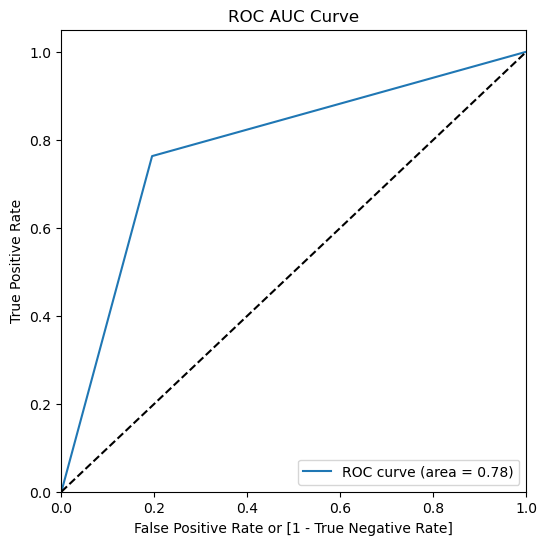

In [1521]:
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred_pca)

In [1522]:
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred_pca))

'0.78'

##### Make a little more unsupervised.

In [1523]:
pca_var_ratio = PCA(0.95)
lr_pca_var_ratio = LogisticRegression()

In [1524]:
X_train_scaled_pca = pca_var_ratio.fit_transform(X_train_scaled)

In [1525]:
X_val_scaled_pca = pca_var_ratio.transform(X_val_scaled)

In [1526]:
logreg_pca_1 = lr_pca_var_ratio.fit(X_train_scaled_pca, y_train_smote)

In [1527]:
y_val_pred_pca = logreg_pca_1.predict(X_val_scaled_pca)

In [1528]:
confusion_pca = confusion_matrix(y_true=y_val, y_pred=y_val_pred_pca)
print(confusion_pca)

[[2666  559]
 [  65  209]]


In [1529]:
metrics_pca_df = calculate_classification_metrics(y_true=y_val, y_pred=y_val_pred_pca)
metrics_pca_df

Confusion Matrix

[[2666  559]
 [  65  209]]


,Metric,Value
0,Accuracy,0.8217
1,Sensitivity,0.7628
2,Specificity,0.8267
3,Precision,0.2721
4,False Positive Rate,0.1733
5,True Positive Rate,0.7628


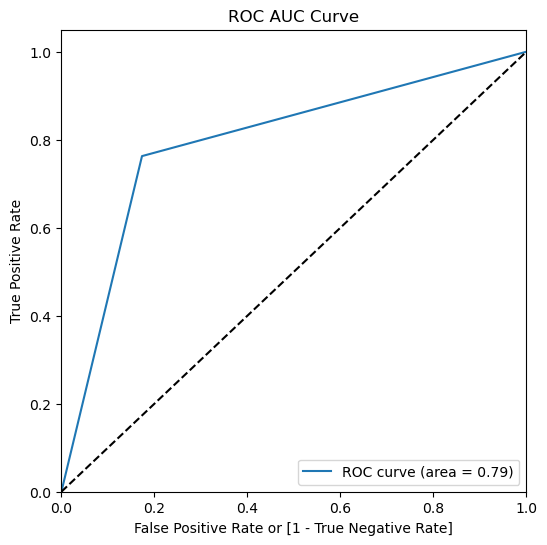

In [1530]:
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred_pca)

In [1531]:
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred_pca))

'0.79'

#### Model 3 : Decision Tree with PCA and GridSearchCV

In [1532]:
dt = DecisionTreeClassifier(random_state=42)
pca = PCA(0.95)

In [1533]:
# Create a pipeline
pipe = make_pipeline(
    pca,
    dt
)

In [1534]:
# Create the parameter grid based on the results of random search 
params = {
    'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
    'decisiontreeclassifier__min_samples_leaf': [5, 10, 20, 50, 100]
}

In [1535]:
# Instantiate the grid search model
grid_search_dt = GridSearchCV(estimator=pipe, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "accuracy")

In [1536]:
# Fit the GridSearchCV
grid_search_dt.fit(X_train_scaled, y_train_smote)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__max_depth': [2, 3, 5, 10, 20],
                         'decisiontreeclassifier__min_samples_leaf': [5, 10, 20,
                                                                      50,
                                                                      100]},
             scoring='accuracy', verbose=1)

In [1537]:
# Get the best parameters and the best score
best_params = grid_search_dt.best_params_
best_score = grid_search_dt.best_score_
print(best_params)
print(best_score)

# Predict on train set using the best model
y_train_pred = grid_search_dt.predict(X_train_scaled)

# Predict on validation set using the best model
y_val_pred = grid_search_dt.predict(X_val_scaled)

{'decisiontreeclassifier__max_depth': 20, 'decisiontreeclassifier__min_samples_leaf': 5}
0.8649000601495628


In [1538]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[2781  444]
 [ 135  139]]


,Metric,Value
0,Accuracy,0.8345
1,Sensitivity,0.5073
2,Specificity,0.8623
3,Precision,0.2384
4,False Positive Rate,0.1377
5,True Positive Rate,0.5073


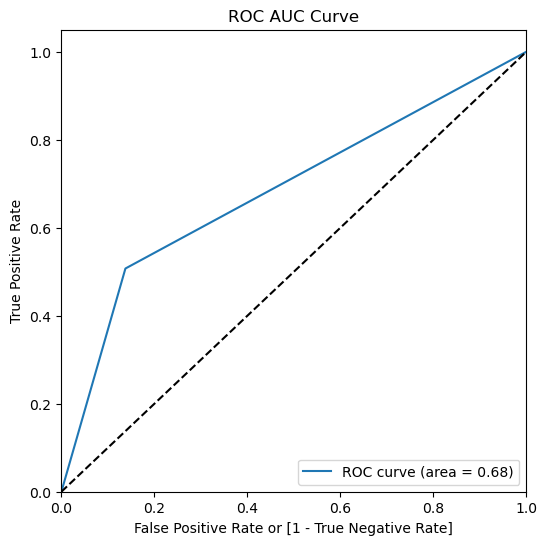

In [1539]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [1540]:
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.68'

In [1541]:
grid_search_dt.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=20, min_samples_leaf=5,
                                        random_state=42))])

#### Random Forest Classifier with PCA and Hyperparameter Tuning

In [1542]:
rf = RandomForestClassifier(random_state=42)

In [1543]:
# Create a pipeline
pipe = make_pipeline(
    pca,
    rf
)

In [1544]:
# Define the hyperparameters grid for Random Forest
param_grid = {
    'randomforestclassifier__n_estimators': [100],  
    'randomforestclassifier__max_depth': [5, 10, 20],       
    'randomforestclassifier__min_samples_split': [2, 5, 10, 20],
}

In [1545]:
grid_search_rf = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [1546]:
# Fit the grid search to the training data
grid_search_rf.fit(X_train_scaled, y_train_smote)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10, 20],
                         'randomforestclassifier__min_samples_split': [2, 5, 10,
                                                                       20],
                         'randomforestclassifier__n_estimators': [100]},
             scoring='accuracy', verbose=1)

In [1547]:
# Get the best parameters and the best score
best_params = grid_search_rf.best_params_
best_score = grid_search_rf.best_score_
print(best_params)
print(best_score)

# Predict on train set using the best model
y_train_pred = grid_search_rf.predict(X_train_scaled)

# Predict on validation set using the best model
y_val_pred = grid_search_rf.predict(X_val_scaled)

{'randomforestclassifier__max_depth': 20, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 100}
0.9457423979277222


In [1548]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3001  224]
 [ 140  134]]


,Metric,Value
0,Accuracy,0.8960
1,Sensitivity,0.4891
2,Specificity,0.9305
3,Precision,0.3743
4,False Positive Rate,0.0695
5,True Positive Rate,0.4891


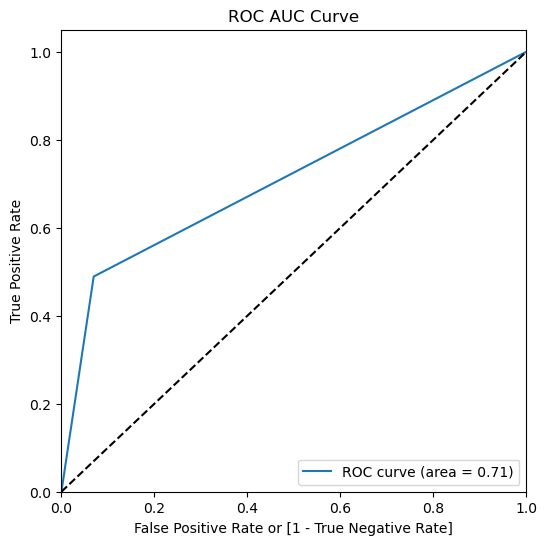

In [1549]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [1550]:
"{:2.2f}".format(roc_auc_score(y_val, y_val_pred))

'0.71'

In [1551]:
grid_search_rf.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, random_state=42))])

#### Model 5 : AdaBoost Classifier

In [1552]:
# Create a pipeline
pipe = make_pipeline(
    pca,
    AdaBoostClassifier(n_estimators=200, random_state=42)
)

In [1553]:
# Build the model
adaboost_model = pipe.fit(X_train_scaled, y_train_smote)

In [1554]:
# Predict on train set using the validation model
y_val_pred = adaboost_model.predict(X_val_scaled)

In [1555]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[2773  452]
 [ 101  173]]


,Metric,Value
0,Accuracy,0.8420
1,Sensitivity,0.6314
2,Specificity,0.8598
3,Precision,0.2768
4,False Positive Rate,0.1402
5,True Positive Rate,0.6314


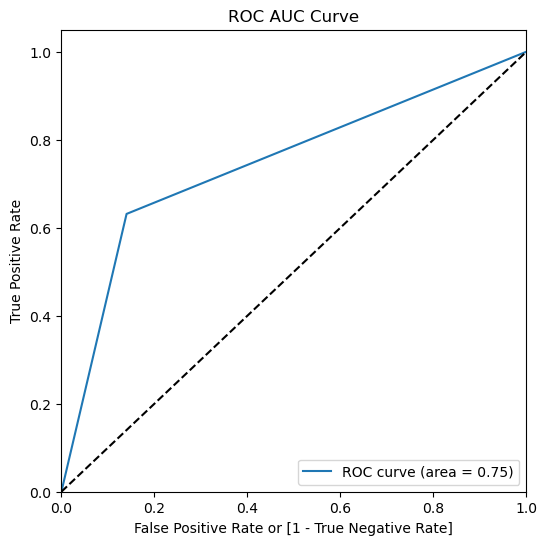

In [1556]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

#### Model 6 : XGBoost Classifier

In [1557]:
!pip install xgboost

In [1558]:
import xgboost as xgb
from xgboost import XGBClassifier

In [1559]:
# Create a pipeline
pipe = make_pipeline(
    pca,
    XGBClassifier(random_state=42)
)

In [1560]:
# Define hyperparameters for grid search
param_grid = {
    'xgbclassifier__n_estimators': [100, 200, 300],  
    'xgbclassifier__max_depth': [3, 5, 7],
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.3]
}

In [1561]:
# Instantiate GridSearchCV
grid_search_boost = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [1562]:
# Fit the grid search to the training data
grid_search_boost.fit(X_train_scaled, y_train_smote)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      impor...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'xgbclassifier__learning_rate': [0.01, 0.1, 0.3],
                         'xgbclassifier__max_depth': [3, 5, 7],
                         'xgbclassifier__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [1563]:
# Get the best parameters and the best score
best_params = grid_search_boost.best_params_
best_score = grid_search_boost.best_score_
print(best_params)
print(best_score)

# Predict on train set using the best model
y_train_pred = grid_search_boost.predict(X_train_scaled)

# Predict on validation set using the best model
y_val_pred = grid_search_boost.predict(X_val_scaled)

{'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 7, 'xgbclassifier__n_estimators': 300}
0.9613503118559024


In [1564]:
# Metrics on the validation set
calculate_classification_metrics(y_val, y_val_pred)

Confusion Matrix

[[3044  181]
 [ 141  133]]


,Metric,Value
0,Accuracy,0.9080
1,Sensitivity,0.4854
2,Specificity,0.9439
3,Precision,0.4236
4,False Positive Rate,0.0561
5,True Positive Rate,0.4854


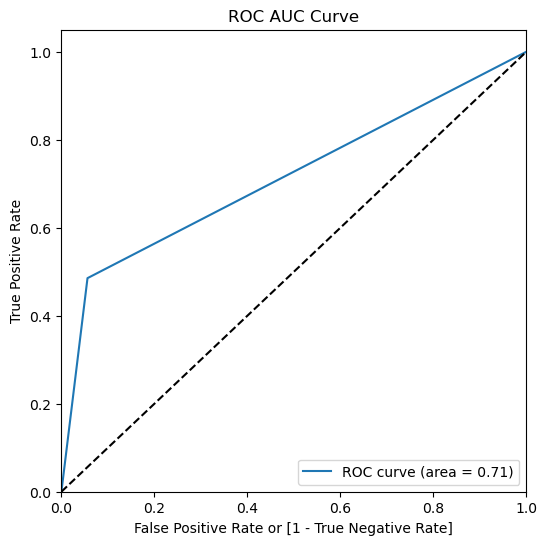

In [1565]:
# ROC curve
fpr, tpr, thresholds = draw_roc(y_val, y_val_pred)

In [1566]:
# Choose Best Model
# Notebook cleanup, comments
# Create a submission file

# Kaggle related stuff
# Factors identification
# Business Recommendations

##### Choose Best Model

- Overall accuracy will be the primary evaluation metric for the telecom churn model: 
We observe that the models 'Logistic Regression with RFE', 'Logistic Regression with PCA', 'Decision Tree with PCA', and 'AdaBoostClassifier' overall accuracy is good. But models 'Random Forest Classifier with PCA and Hyperparameter Tuning', and 'XGBoost Classifier' have more accuracy.

- Also consider other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on our business objective to identify customers who'll definitely churn with more accuracy than the ones who'll not churn: 
We observe that the models 'Logistic Regression with RFE', and 'Logistic Regression with PCA' have good sensitivity or recall metrics compared to other models whose specificity is good but sensitivity/True Positive Rate/Recall is not good.
If the Model objective is to find the customers who will not churn, then Specifity can be considered.

- Final Model and metrics on test set: 
We recommend the model 'Logistic Regression with RFE' for telecom churn prediction with an overall accuracy of 0.83 and a Sensitivity/Recall/True Positive Rate has 0.799. Looking at the specificity metric, which determines customers who will not churn is also good at 0.83.

#### Creating submission file

In [1567]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [1569]:
submission_data = final_unseen_df_scaled[selected_features]
submission_data.shape

(30000, 20)

In [1570]:
final_unseen_df_scaled_logreg = final_unseen_df_scaled

In [1571]:
final_unseen_df_scaled_logreg['churn_probability'] = logreg.predict(submission_data)
final_unseen_df_scaled_logreg = pd.concat([unseen_id_df, final_unseen_df_scaled_logreg], axis = 1)

In [1572]:
output_logreg = final_unseen_df_scaled_logreg[['id', 'churn_probability']]

In [1574]:
output_logreg.to_csv('submission_logreg.csv',index=False)

In [1575]:
final_unseen_df_scaled_boost = final_unseen_df_scaled

In [1576]:
if 'churn_probability' in final_unseen_df_scaled_boost.columns:
        final_unseen_df_scaled_boost = final_unseen_df_scaled_boost.drop(columns=['churn_probability'])

In [1577]:
final_unseen_df_scaled_boost['churn_probability'] = grid_search_boost.predict(final_unseen_df_scaled_boost)

In [1578]:
final_unseen_df_scaled_boost = pd.concat([unseen_id_df, final_unseen_df_scaled_boost], axis = 1)

In [1579]:
output_boost = final_unseen_df_scaled_boost[['id', 'churn_probability']]

In [1581]:
output_boost.to_csv('submission_boost.csv',index=False)

In [1583]:
final_unseen_df_scaled_random_forest = final_unseen_df_scaled

In [1584]:
if 'churn_probability' in final_unseen_df_scaled_random_forest.columns:
        final_unseen_df_scaled_random_forest = final_unseen_df_scaled_random_forest.drop(columns=['churn_probability'])

In [1585]:
final_unseen_df_scaled_random_forest['churn_probability'] = grid_search_rf.predict(final_unseen_df_scaled_random_forest)

In [1586]:
final_unseen_df_scaled_random_forest = pd.concat([unseen_id_df, final_unseen_df_scaled_random_forest], axis = 1)

In [1587]:
output_rand_forest = final_unseen_df_scaled_random_forest[['id', 'churn_probability']]

In [1588]:
output_rand_forest.to_csv('submission_random_forest.csv',index=False)

In [1590]:
final_unseen_df_scaled_ada_boost = final_unseen_df_scaled

In [1591]:
if 'churn_probability' in final_unseen_df_scaled_ada_boost.columns:
        final_unseen_df_scaled_ada_boost = final_unseen_df_scaled_ada_boost.drop(columns=['churn_probability'])

In [1592]:
final_unseen_df_scaled_ada_boost['churn_probability'] = adaboost_model.predict(final_unseen_df_scaled_ada_boost)

In [1593]:
final_unseen_df_scaled_ada_boost = pd.concat([unseen_id_df, final_unseen_df_scaled_ada_boost], axis = 1)

In [1594]:
output_ad_boost = final_unseen_df_scaled_ada_boost[['id', 'churn_probability']]

In [1595]:
output_ad_boost.to_csv('submission_ad_boost.csv',index=False)

In [1596]:
# Logistic Regression important features 
selected_features

Index(['onnet_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_mou_8',
       'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8',
       'isd_ic_mou_8', 'total_og_mou_8', 'total_ic_mou_7', 'total_ic_mou_8',
       'max_rech_data_7', 'sachet_2g_7', 'fb_user_8_1.0',
       'night_pck_user_7_0.0'],
      dtype='object')